In [2]:
import scanpy as sc
import pandas as pd 
import numpy as np
import os
import re
import glob
import scipy as sp
import matplotlib
from matplotlib import rcParams
from matplotlib import colors
import matplotlib.pyplot as plt

In [3]:
# data downloaded from GEO https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE116256 and extracted
samples = pd.read_csv('../data/van_Galen/sample_names.txt', header = None)[0].values
#sample_names.txt was generated by running ls *.dem.txt.gz | grep -o '[^_]*$' | awk -F\. '{print $1}' > sample_names.txt

In [4]:
# read in data downloaded from GEO - GSE116256
adatas = []
for i in range(0, len(samples)):
    d_fpattern = r'../data/van_Galen/{}_{}.dem.txt.gz'
    d_file = glob.glob(d_fpattern.format('*', samples[i]))
    data = pd.read_csv(d_file[0], sep = '\t', index_col = 0)
    a_fpattern = r'../data/van_Galen/{}_{}.anno.txt.gz'
    a_file = glob.glob(a_fpattern.format('*', samples[i]))
    meta = pd.read_csv(a_file[0], sep = '\t', index_col = 0)
    adata = sc.AnnData(X = data.T, obs = meta)
    adatas.append(adata)            

In [5]:
adata_all = adatas[0].concatenate(adatas[1:], batch_key='sample_ID', index_unique=None)
adata_all

AnnData object with n_obs × n_vars = 41090 × 27899
    obs: 'NumberOfReads', 'AlignedToGenome', 'AlignedToTranscriptome', 'TranscriptomeUMIs', 'NumberOfGenes', 'CyclingScore', 'CyclingBinary', 'MutTranscripts', 'WtTranscripts', 'PredictionRF2', 'PredictionRefined', 'CellType', 'Score_HSC', 'Score_Prog', 'Score_GMP', 'Score_ProMono', 'Score_Mono', 'Score_cDC', 'Score_pDC', 'Score_earlyEry', 'Score_lateEry', 'Score_ProB', 'Score_B', 'Score_Plasma', 'Score_T', 'Score_CTL', 'Score_NK', 'NanoporeTranscripts', 'sample_ID'

In [7]:
# add some extra metadata
adata_all.obs['dataset'] = 'vanG'
adata_all.obs['sample'] = adata_all.obs_names.str.extract(r'([^_]+)')[0].values # sampleID
adata_all.obs['donor'] = adata_all.obs['sample'].str.extract(r'([^-]+)')[0].values 
don_status = np.array(adata_all.obs['sample']) # is donor healthy or AML
don_status[np.where(adata_all.obs['sample'].str.contains('AML'))] = 'AML'
don_status[np.where(adata_all.obs['sample'].str.contains('BM'))] = 'healthy'
adata_all.obs['donor_status'] =  don_status
adata_all.obs.rename(columns = {'PredictionRefined':'cell_status'}, inplace = True)
adata_all

AnnData object with n_obs × n_vars = 41090 × 27899
    obs: 'NumberOfReads', 'AlignedToGenome', 'AlignedToTranscriptome', 'TranscriptomeUMIs', 'NumberOfGenes', 'CyclingScore', 'CyclingBinary', 'MutTranscripts', 'WtTranscripts', 'PredictionRF2', 'cell_status', 'CellType', 'Score_HSC', 'Score_Prog', 'Score_GMP', 'Score_ProMono', 'Score_Mono', 'Score_cDC', 'Score_pDC', 'Score_earlyEry', 'Score_lateEry', 'Score_ProB', 'Score_B', 'Score_Plasma', 'Score_T', 'Score_CTL', 'Score_NK', 'NanoporeTranscripts', 'sample_ID', 'dataset', 'sample', 'donor', 'donor_status'

In [8]:
# remove cell line samples because we're not interested in those
adata_all = adata_all[~((adata_all.obs['sample'].str.contains('OCI')) | (adata_all.obs['sample'].str.contains('MUTZ3')))]
adata_all

View of AnnData object with n_obs × n_vars = 38410 × 27899
    obs: 'NumberOfReads', 'AlignedToGenome', 'AlignedToTranscriptome', 'TranscriptomeUMIs', 'NumberOfGenes', 'CyclingScore', 'CyclingBinary', 'MutTranscripts', 'WtTranscripts', 'PredictionRF2', 'cell_status', 'CellType', 'Score_HSC', 'Score_Prog', 'Score_GMP', 'Score_ProMono', 'Score_Mono', 'Score_cDC', 'Score_pDC', 'Score_earlyEry', 'Score_lateEry', 'Score_ProB', 'Score_B', 'Score_Plasma', 'Score_T', 'Score_CTL', 'Score_NK', 'NanoporeTranscripts', 'sample_ID', 'dataset', 'sample', 'donor', 'donor_status'

In [9]:
# need to normalise data because only counts were available from GEO 
# according to paper they just used counts per 10,000
adata_all.layers['counts'] = adata_all.X
sc.pp.normalize_total(adata_all, target_sum = 1e4)
sc.pp.log1p(adata_all)

In [10]:
# write out data
adata_all.write('../data/van_Galen/van_Galen.h5ad')

... storing 'CyclingBinary' as categorical
... storing 'MutTranscripts' as categorical
... storing 'WtTranscripts' as categorical
... storing 'PredictionRF2' as categorical
... storing 'cell_status' as categorical
... storing 'CellType' as categorical
... storing 'NanoporeTranscripts' as categorical
... storing 'dataset' as categorical
... storing 'sample' as categorical
... storing 'donor' as categorical
... storing 'donor_status' as categorical


--------------------
I used `singleR.R` script to predict cell types using the Granja data as reference. Going to see what they look like now and save them to the h5ad file.

In [11]:
adata = sc.read('../data/van_Galen/van_Galen.h5ad') # read in data
labs = pd.read_csv('../data/van_Galen/van_Galen_cell_labels.csv', sep='\t') # read in labels
adata.obs['celltype'] = labs['label']
adata

AnnData object with n_obs × n_vars = 38410 × 27899
    obs: 'NumberOfReads', 'AlignedToGenome', 'AlignedToTranscriptome', 'TranscriptomeUMIs', 'NumberOfGenes', 'CyclingScore', 'CyclingBinary', 'MutTranscripts', 'WtTranscripts', 'PredictionRF2', 'cell_status', 'CellType', 'Score_HSC', 'Score_Prog', 'Score_GMP', 'Score_ProMono', 'Score_Mono', 'Score_cDC', 'Score_pDC', 'Score_earlyEry', 'Score_lateEry', 'Score_ProB', 'Score_B', 'Score_Plasma', 'Score_T', 'Score_CTL', 'Score_NK', 'NanoporeTranscripts', 'sample_ID', 'dataset', 'sample', 'donor', 'donor_status', 'celltype'
    layers: 'counts'

/home/sennis/anaconda3/lib/python3.7/site-packages/numba/core/typed_passes.py:332: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../home/sennis/anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/sennis/anaconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../home/sennis/anaconda3/

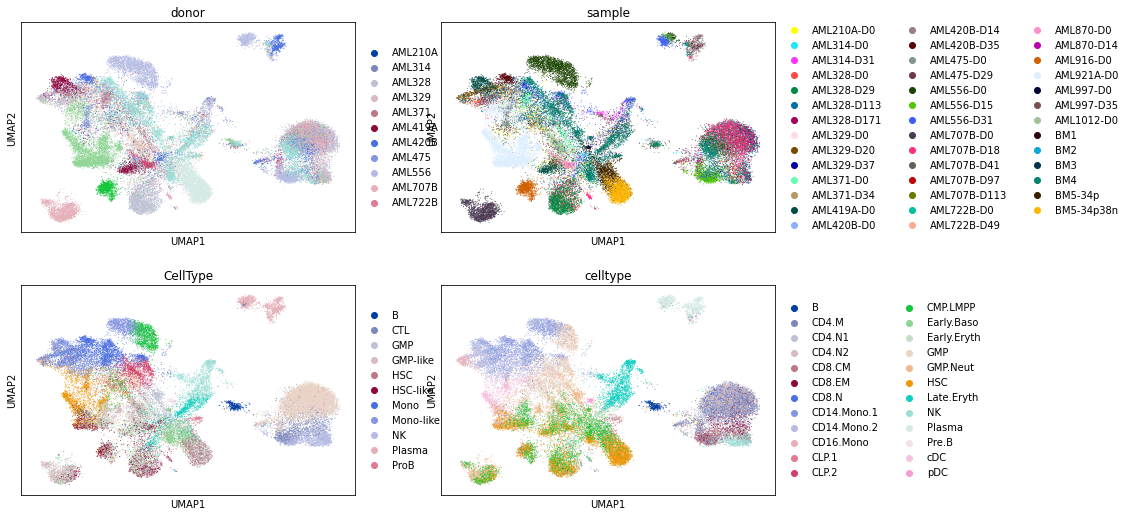

In [12]:
# visualise cells
adata.X = sp.sparse.csr_matrix(adata.X) # need to convert to sparse matrix because it will throw errors downstream
sc.pp.highly_variable_genes(adata, n_top_genes=4000)
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['donor', 'sample', 'CellType', 'celltype'], ncols=2)

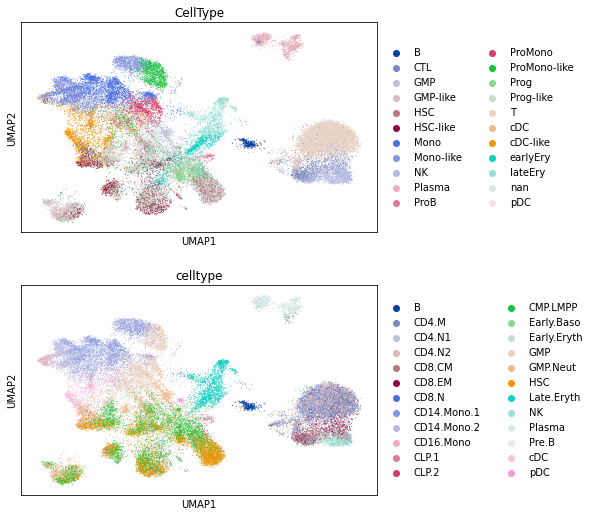

In [13]:
# zoom in on celltypes
sc.pl.umap(adata, color=['CellType', 'celltype'], ncols=1)

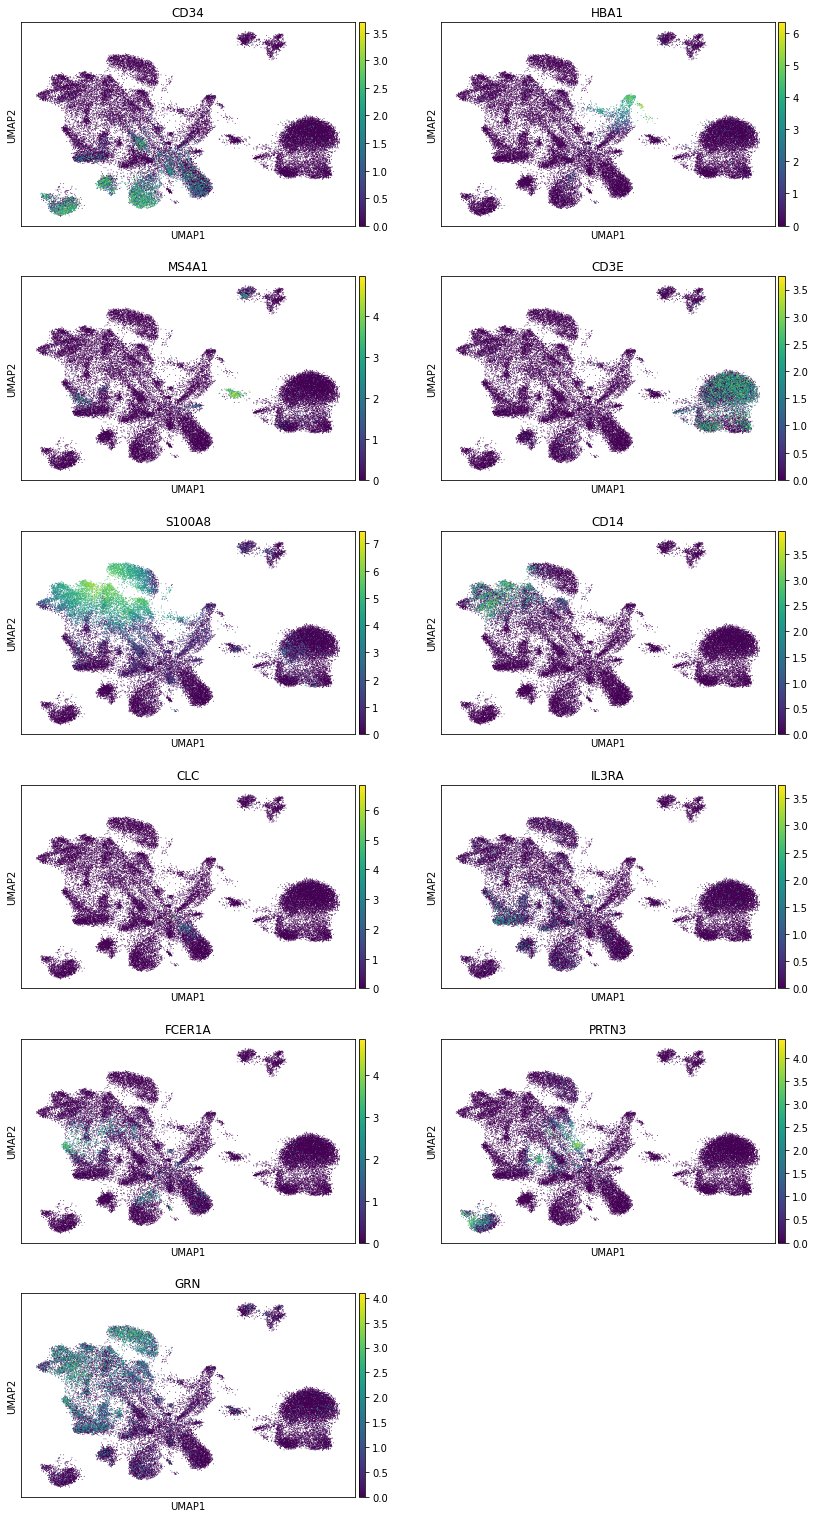

In [14]:
# make sure cells are expressing genes you'd expect
sc.pl.umap(adata, color=['CD34', 'HBA1', 'MS4A1', 'CD3E', 'S100A8',
                         'CD14', 'CLC', 'IL3RA', 'FCER1A','PRTN3', 'GRN'], ncols=2)

Predicted cell types line up very well with the original cell type labels but give more resolution for the T cell clusters in particular. Happy with these labels now.

In [15]:
adata.write('../data/van_Galen/van_Galen.h5ad')